### Prepare Source Dataset

In [1]:
nba = read.csv("./nbadata.csv")
player_name = "Jeremy Lin"
player_shot_records = nba[nba$PLAYER_NAME == player_name,]

### Prepare Self Define Function Libarary

#### General Functions

In [61]:
percentage = function(number) {
    return(paste(round(number, 3)*100,"%"))
}
show = function(m_matrix, titles, data) {
    rows_count = nrow(m_matrix)
    cols_count = ncol(m_matrix)
    for(i in c(1:rows_count)) {
        if(i %% 2 == 1) {
            m_matrix[i, ] = titles[(i%/%2*cols_count+1):((i%/%2+1)*cols_count)]
        } else {
            m_matrix[i, ] = data[(i%/%2*cols_count-cols_count+1):((i%/%2)*cols_count)]
        }
    }
    return(m_matrix)
}

#### Statistic Related Functions

In [244]:
get_player_per_game_statistics = function(player_shot_records, func) {
    game_ids = unique(player_shot_records$GAME_ID)
    statistics = c()
    i = 1
    for (game_id in game_ids) {
        statistics[i] = func(player_shot_records, game_id)
        i = i + 1
    }
    return(statistics)
}

get_player_score_per_game = function(player_shot_records, game_id) {
    score = sum(player_shot_records[player_shot_records$GAME_ID == game_id, "PTS"])
    return(score)
}

get_location_per_game = function(player_shot_records, game_id) {
    loc = as.numeric(player_shot_records[player_shot_records$GAME_ID==game_id, "LOCATION"][1])
    if(loc == 1) {
        return(0)
    }
    else {
        return(1)
    } 
}

get_final_margin_per_game = function(player_shot_records, game_id) {
    return(player_shot_records[player_shot_records$GAME_ID==game_id, "FINAL_MARGIN"][1])
}

get_shot_number_per_game = function(player_shot_records, game_id) {
    return(max(player_shot_records[player_shot_records$GAME_ID==game_id, "SHOT_NUMBER"]))
}

get_average_shot_clock_per_game = function(player_shot_records, game_id) {
    shot_clock = mean(player_shot_records[player_shot_records$GAME_ID==game_id, "SHOT_CLOCK"])
    if (is.na(shot_clock)) {
        return(mean(player_shot_records[, "SHOT_CLOCK"], na.rm=TRUE))
    }
    else {
        return(shot_clock)
    }
}

get_average_dribbles_per_game = function(player_shot_records, game_id) {
    return(mean(player_shot_records[player_shot_records$GAME_ID==game_id, "DRIBBLES"]))
}

get_average_touch_time_per_game = function(player_shot_records, game_id) {
    return(mean(player_shot_records[player_shot_records$GAME_ID==game_id,"TOUCH_TIME"]))
}

get_average_shot_distance_per_game = function(player_shot_records, game_id) {
    return(mean(player_shot_records[player_shot_records$GAME_ID==game_id, "SHOT_DIST"]))
}

#### Statistic Test Related Functions

In [ ]:
get_CI_from_one_sample_bernoulli = function(positive_data, total_data, alpha=0.05) {
    positive_count = length(positive_data)
    total = length(total_data)
    estimated_percentage = positive_count / total
    estimated_variance = estimated_percentage * (1 - estimated_percentage)
    degree_of_freedom = total - 1
    CI = 1 - alpha / 2
    t = pt(CI, degree_of_freedom)
    lower_CI = estimated_percentage - t*sqrt(estimated_variance/total)
    upper_CI = estimated_percentage + t*sqrt(estimated_variance/total)
    titles = c(
        "Confidence", "Sample Mean", "Sample Variance",
        "Number of Samples", "Degree of Freedom", "Confidence Interval"
    )
    data = c(
        percentage(1-alpha), percentage(estimated_percentage), round(estimated_variance, 2),
        total, degree_of_freedom, 
        paste("[", percentage(lower_CI), ",", percentage(upper_CI), "]")
    )
    return(show(matrix(nrow = 4, ncol = 3), titles, data))
}

get_test_result_from_two_sample_bernoulli = function(H0, H1,
                                                     positive_data1, data1, 
                                                     positive_data2, data2, 
                                                     alpha=0.05, alternative="two.sided") {
    positive_data1_count = length(positive_data1)
    positive_data2_count = length(positive_data2)
    data1_count = length(data1)
    data2_count = length(data2)
    p1_hat = positive_data1_count / data1_count
    p2_hat = positive_data2_count / data2_count
    p_hat_based_H0 = (positive_data1_count + positive_data2_count) / (data1_count + data2_count)
    variance_based_equal_variance = p_hat_based_H0*(1-p_hat_based_H0)/data1_count + p_hat_based_H0*(1-p_hat_based_H0)/data2_count
    statistic = (p1_hat - p2_hat) / sqrt(variance_based_equal_variance) 
    degree_of_freedom = data1_count + data2_count - 2
    if(alternative == "two.sided") {
        p_value = 2 * (1 - pt(abs(statistic), degree_of_freedom))
    } else if(alternative == "greater") {
        p_value = 1 - pt(statistic, degree_of_freedom)
    } else if(alternative == "less") {
        p_value = pt(statistic, degree_of_freedom)
    }
    estimated_variance = p1_hat*(1-p1_hat)/data1_count + p2_hat*(1-p2_hat)/data2_count
    difference_lower_CI = (p1_hat - p2_hat) - qt(0.975, degree_of_freedom) * estimated_variance
    difference_higher_CI = (p1_hat - p2_hat) + qt(0.975, degree_of_freedom) * estimated_variance
    difference_confidence_interval = paste("[", percentage(difference_lower_CI), ",", percentage(difference_higher_CI), "]")
    titles = c(
        "p_hat1", "p_hat2", "difference confidence interval(95%)",
        "Number of Samples1", "Number of Samples2", "Degree of Freedom",
        "H0", "H1", "P Value"
    )
    data = c(
        percentage(p1_hat), percentage(p2_hat), difference_confidence_interval,
        data1_count, data2_count, degree_of_freedom,
        H0, H1, p_value
    )
    return(show(matrix(nrow=6, ncol=3), titles, data))
}

get_test_result_from_one_sample_multinoulli_test = function(data, alpha=0.05) {
    total = length(data)
    categories = unique(data)
    categories_num = length(categories)
    categories_count = c()
    m = matrix(nrow=2, ncol=categories_num)
    for(i in 1:categories_num) {
        categories_count[i] = sum(data == categories[i])
    }
    m[1,] = categories
    m[2,] = categories_count
    estimated_percentage = 1 / categories_num
    degree_of_freedom = categories_num - 1
    E = total * estimated_percentage
    chisquare_statistic = 0
    for(i in 1:categories_num) {
        chisquare_statistic = chisquare_statistic + (as.numeric(m[2,i]) - E)^2/E
    }
    p_value = 1 - pchisq(chisquare_statistic, degree_of_freedom)
    titles = c("Categories", "Number of Each Categories", "P-Value")
    data = c(
        paste(categories, collapse=","),
        paste(categories_count, collapse=","),
        p_value
    )
    return(show(matrix(nrow=2, ncol=3), titles, data))
}

#### Model Related Functions

##### Linear Regression

In [317]:
get_parameters_by_least_squares_estimators = function(X, y) {
    parameters = pseudoinverse(X) %*% y
    return(parameters)
}

get_sst_sse_ssm_of_linear_models = function(X, y, parameters) {
    sst = sum((y - mean(y))^2)
    predictions = X %*% parameters
    sse = sum((y - predictions)^2)
    ssm = sst - sse
    return(c(sst, sse, ssm))
}

get_anova_table_for_linear_relationship_test = function(X, y, parameters) {
    number_of_predictors = dim(X)[2] 
    number_of_rows = nrow(X)
    df_model = number_of_predictors - 1
    df_res = number_of_rows - number_of_predictors
    df_total = number_of_rows - 1
    sst_sse_ssm = get_sst_sse_ssm_of_linear_models(X, y, parameters)
    sst = sst_sse_ssm[1]
    ssr = sst_sse_ssm[2]
    ssm = sst_sse_ssm[3]
    mean_ssm = ssm / df_model
    mean_sse = ssr / df_res
    f_statistic = mean_ssm / mean_sse
    p_value = 1 - pf(f_statistic, df_model, df_res)
    summary_matrix = matrix(nrow=4, ncol=6)
    r1 = c("Source of Variation", "Sum of Squares", "Degrees of Freedom", "Mean Square", "F0", "P-Value")
    r2 = c("Model", round(ssm,2), round(df_model,2), round(mean_ssm,2), round(f_statistic,2), p_value)
    r3 = c("Residual", round(ssr,2), round(df_res,2), round(mean_sse,2), "-", "-")
    r4 = c("Total", round(sst,2), round(df_total,2), "-", "-", "-")
    summary_matrix[1,]=r1
    summary_matrix[2,]=r2
    summary_matrix[3,]=r3
    summary_matrix[4,]=r4
    return(summary_matrix)
}

get_cov_of_betas = function(X) {
    cov_of_betas = solve(t(X) %*% X)
    return(cov_of_betas)
}

get_estimated_sigma = function(X, y, parameters) {
    sse = get_sst_sse_ssm_of_linear_models(X, y, parameters)[2]
    num_preditors = dim(X)[2]
    estimated_sigma = sqrt(sse / (dim(X)[1] - num_preditors))
    return(estimated_sigma)
}

get_individual_variable_p_value = function(i, cov_of_betas, estimated_beta, estimated_sigma, degree_of_freedom) {
    statistic = estimated_beta / (cov_of_betas[i,i] * estimated_sigma)
    p_value = 2 * (1 - pt(abs(statistic), degree_of_freedom))
    return(p_value)
}

get_influential_variables = function(X, y, parameters, predictors, alpha=0.05) {
    if (length(parameters) == 0) {
        return
    }
    min_p_value = Inf
    min_p_value_index = NA
    cov_of_betas = get_cov_of_betas(X)
    estimated_sigma = get_estimated_sigma(X, y, parameters)
    df = dim(X)[1] - length(predictors)
    # 2 because we do not exclude intercept
    for(i in 2:length(parameters)) {
        p_value = get_individual_variable_p_value(i, cov_of_betas, parameters[i], estimated_sigma, df)
        if(p_value < min_p_value) {
            min_p_value_index = i
            min_p_value = p_value
        }
    }
    if(min_p_value_index==length(predictors)){
        updated_predictors = predictors[1:(length(predictors)-1)]
    } 
    else{
        updated_predictors = c(predictors[1:(min_p_value_index-1)], predictors[(min_p_value_index+1):length(predictors)])
    } 
    updated_parameters = get_parameters_by_least_squares_estimators(X[, updated_predictors], y) 
    p_value = get_anova_table_for_linear_relationship_test(
        X[, updated_predictors], y, updated_parameters
    )[2,6] 
    cat(
        sprintf(
            "The most influential predictor:%s, The p_value:%f\n",
            predictors[min_p_value_index],
            min_p_value
        )
    )
    if(as.numeric(p_value) >= alpha | as.numeric(min_p_value) >= alpha) {
        return("Done")
    }
    get_influential_variables(X[, updated_predictors], y, updated_parameters, updated_predictors)
}

##### Logistic Regression

In [191]:
get_logistic_regression_probability_predictions = function(X, parameters) {
    e_part_vector = exp(-(X %*% parameters))
    p_vector = 1 / (1+e_part_vector)     
    return(p_vector)
}

get_logistic_regression_cost = function(X, y, probability_predictions) {
    m = nrow(X)
    true_label_loss = -(t(y)%*%log(probability_predictions))
    false_label_loss = -(t((1-y))%*%log(1-probability_predictions))
    cost = 1/m * (true_label_loss + false_label_loss)
    return(cost)
}

optimize_logistic_regression_parameters = function(X, y, probability_predictions, 
                                                   parameters, learning_rate=0.001) {
    number_of_features = dim(X)[2]
    part1 = t(X)
    part2 = probability_predictions - y
    gradient = part1 %*% part2
    gradient = gradient/(number_of_features)
    gradient = gradient * learning_rate
    parameters = parameters - gradient
    return(parameters)
}

get_logistic_final_parameters = function(X, y, parameters, 
                                         learning_rate=0.001, itr_number=12000) {
    cost_before = Inf
    for(i in 0:itr_number) {
        probability_predictions = get_logistic_regression_probability_predictions(X, parameters)
        cost = get_logistic_regression_cost(X, y, probability_predictions)
        if(i%%1000 == 0) {
            cat(sprintf("The cost in %f is: %f \n", i, cost))
        } else if(cost<0.1) {
            cat(sprintf("(cost<0.1)The cost in %f is: %f \n", i, cost))
            return(parameters)
        } 
        parameters = optimize_logistic_regression_parameters(X, y, probability_predictions, parameters, learning_rate)
        cost_before = cost
    }
    return(parameters)
}

get_model_for_predict_fgm = function(train_X, train_y) {
    initial_parameters = get_parameters_by_least_squares_estimators(train_X, train_y)
    parameters = get_logistic_final_parameters(train_X, train_y, initial_parameters)
    return(parameters)
}

show_logistic_regression_parameters = function(predictors, parameters) {
    predictors = c("INTERCEPT", predictors)
    return(show(matrix(nrow=4, ncol=5), predictors, round(parameters, 4)))
}

decision_boundary = function(probability_predictions) {
    predictions = probability_predictions > 0.5
    return(as.numeric(predictions))
}

get_log_likelihood = function(X, y, parameters) {
    return( 
        sum(y * (X %*% parameters) - log(1+exp(X %*% parameters)))
    )
}

get_deviance_test_result = function(X, y, full_features_parameters, ordered_abs_parameters) {
    log_likelihood = get_log_likelihood(X, y, full_features_parameters)
    log_likelihoods = c(log_likelihood)
    deviances = c(0)
    p_values = c(1)
    features = c("FULL FEATURES")
    for( i in 1:(length(ordered_abs_parameters[, 1])-1) ) {
        reduced_predictors = c("intercept", ordered_abs_parameters[-(1:i), 1])
        print(reduced_predictors)
        parameters = get_model_for_predict_fgm(X[, reduced_predictors], y)
        log_likelihoods[i+1] = get_log_likelihood(X[, reduced_predictors], y, parameters)
        deviances[i+1] = round(2*(log_likelihoods[1] - log_likelihoods[i+1]), 5)
        p_values[i+1] = round(1 - pchisq(deviances[i+1], i), 5)
        features[i+1] = paste("then reduce ", ordered_abs_parameters[, 1][i])
    }
    features[2] = paste("reduce ", ordered_abs_parameters[, 1][1])
    summary_matrix = cbind(features, log_likelihoods, deviances, p_values)
    return(summary_matrix)
}

get_logistic_regression_accuracy_precision_and_recall = function(X, y, parameters) {
    probability_predictions = get_logistic_regression_probability_predictions(X, parameters)
    predictions = decision_boundary(probability_predictions)
    n = length(predictions)
    TP = sum(y==1 & predictions==1)
    FP = sum(y==0 & predictions==1)
    FN = sum(y==1 & predictions==0)
    accuracy = sum(y==predictions)/n
    accuracy95_CI = get_CI_from_one_sample_bernoulli(rep(1,accuracy*n), predictions)[4,3]
    precision = TP / (TP+FP)
    precision95_CI = get_CI_from_one_sample_bernoulli(rep(1,precision*n), predictions)[4,3]
    recall = TP / (TP+FN)
    recall95_CI = get_CI_from_one_sample_bernoulli(rep(1,recall*n), predictions)[4,3]
    titles = c(
        "accuracy", "precision", "recall",
        "accuracy 95% CI", "precision 95% CI", "recall 95% CI"
    )
    data = c(
        percentage(accuracy), percentage(precision), percentage(recall),
        accuracy95_CI, precision95_CI, recall95_CI
    )
    return(show(matrix(nrow=4, ncol=3), titles, data))
}

#### Main Functions

In [212]:
summary_player = function(player_shot_records) {
    games_count = length(unique(player_shot_records$GAME_ID))
    shots_count = nrow(player_shot_records)
    home_games_count = length(unique(player_shot_records[player_shot_records$LOCATION=="H",]$GAME_ID))
    away_games_count = games_count - home_games_count
    winning_rate = percentage(length(unique(player_shot_records[player_shot_records$W=="W",]$GAME_ID)) / games_count)
    shooting_percentage = percentage(nrow(player_shot_records[player_shot_records$FGM==1,]) / shots_count)
    two_points_shooting_percentage = percentage(
        nrow(player_shot_records[player_shot_records$FGM==1 & player_shot_records$PTS_TYPE==2,]) / 
        nrow(player_shot_records[player_shot_records$PTS_TYPE==2,])
    )
    three_points_shooting_percentage = percentage(
        nrow(player_shot_records[player_shot_records$FGM==1 & player_shot_records$PTS_TYPE==3,]) / 
        nrow(player_shot_records[player_shot_records$PTS_TYPE==3,])
    )
    average_game_score = round(mean(get_player_per_game_statistics(player_shot_records, get_player_score_per_game)), 2)
    two_points_choices = percentage(nrow(player_shot_records[player_shot_records$PTS_TYPE==2,]) / shots_count)
    three_points_choices = percentage(nrow(player_shot_records[player_shot_records$PTS_TYPE==3,]) / shots_count)
    touch_time_habit = paste(quantile(player_shot_records$TOUCH_TIME, c(0.60)))
    dribble_count_habit = quantile(player_shot_records$DRIBBLES, c(0.60))
    average_shot_clock = round(mean(player_shot_records$SHOT_CLOCK, na.rm=TRUE), 2)
    shots_count_in_1_period = nrow(player_shot_records[player_shot_records$PERIOD==1,])
    shots_count_in_2_period = nrow(player_shot_records[player_shot_records$PERIOD==2,])
    shots_count_in_3_period = nrow(player_shot_records[player_shot_records$PERIOD==3,])
    shots_count_in_4_period = nrow(player_shot_records[player_shot_records$PERIOD==4,])
    titles = c(
        "games_count", "shots_count", "home_games_count", "away_games_count",
        "winning_rate", "shooting_percentage", "two_points_shooting_percentage", "three_points_shooting_percentage",
        "average_game_score", "two_points_choices", "three_points_choices", "touch_time_habit(60%)",
        "dribble_count_habit(60%)", "average_shot_clock", "shots_count_in_1_2_period", "shots_count_in_3_4_period"
    )
    data = c(
        games_count, shots_count, home_games_count, away_games_count,
        winning_rate, shooting_percentage, two_points_shooting_percentage, three_points_shooting_percentage,
        average_game_score, two_points_choices, three_points_choices, touch_time_habit,
        dribble_count_habit, average_shot_clock, 
        paste(shots_count_in_1_period, ",", shots_count_in_2_period), 
        paste(shots_count_in_3_period, ",", shots_count_in_4_period)
    )
    return(show(matrix(nrow = 8, ncol = 4), titles, data))
}

get_fgm_confidence_interval = function() {
    fgm_data = player_shot_records["FGM"]
    fgm_total_samples = fgm_data[TRUE,]
    fgm_positive_samples = fgm_data[fgm_data==1,]
    get_CI_from_one_sample_bernoulli(fgm_positive_samples, fgm_total_samples)
}

compare_2_and_3_shooting_percentage = function() {
    pts_type_data = player_shot_records[c("PTS_TYPE", "SHOT_RESULT")]
    pts2_samples = pts_type_data[pts_type_data$PTS_TYPE == 2 & !is.na(pts_type_data$SHOT_RESULT), "SHOT_RESULT"]
    pts3_samples = pts_type_data[pts_type_data$PTS_TYPE == 3 & !is.na(pts_type_data$SHOT_RESULT), "SHOT_RESULT"]
    pts2_made_samples = pts_type_data[pts_type_data$PTS_TYPE == 2 & pts_type_data$SHOT_RESULT == "made", "SHOT_RESULT"]
    pts3_made_samples = pts_type_data[pts_type_data$PTS_TYPE == 3 & pts_type_data$SHOT_RESULT == "made", "SHOT_RESULT"]
    get_test_result_from_two_sample_bernoulli(
        "POINTS 2 PERCENTAGE = POINTS 3 PERCENTAGE",
        "POINTS 2 PERCENTAGE != POINTS 3 PERCENTAGE",
        pts2_made_samples, pts2_samples, 
        pts3_made_samples, pts3_samples
    )  
}

compare_location_shooting_percentage = function() {
    location_shot_data = player_shot_records[c("LOCATION", "FGM")]
    home_shot_samples = location_shot_data[location_shot_data$LOCATION == "H", "FGM"]
    away_shot_samples = location_shot_data[location_shot_data$LOCATION == "A", "FGM"]
    home_shot_made_samples = location_shot_data[location_shot_data$LOCATION == "H" & location_shot_data$FGM == 1, "FGM"]
    away_shot_made_samples = location_shot_data[location_shot_data$LOCATION == "A" & location_shot_data$FGM == 1, "FGM"]
    get_test_result_from_two_sample_bernoulli(
        "HOME SHOTTING PERCENTAGE = AWAY SHOTTING PERCENTAGE",
        "HOME SHOTTING PERCENTAGE != AWAY SHOTTING PERCENTAGE",
        home_shot_made_samples, home_shot_samples, 
        away_shot_made_samples, away_shot_samples
    ) 
}

compare_win_lose_shooting_percentage = function() {
    game_result_shot_data = player_shot_records[c("W", "FGM")]
    winning_game_shot_samples = game_result_shot_data[game_result_shot_data$W == "W", "FGM"]
    losing_game_shot_samples = game_result_shot_data[game_result_shot_data$W == "L", "FGM"]
    winning_game_shot_made_samples = game_result_shot_data[game_result_shot_data$W == "W" & game_result_shot_data$FGM == 1, "FGM"]
    losing_game_shot_made_samples = game_result_shot_data[game_result_shot_data$W == "L" & game_result_shot_data$FGM == 1, "FGM"]
    get_test_result_from_two_sample_bernoulli(
        "WIN SHOTTING PERCENTAGE = LOSE SHOOTING PERCENTAGE",
        "WIN SHOTTING PERCENTAGE != LOSE SHOOTING PERCENTAGE",
        winning_game_shot_made_samples, winning_game_shot_samples, 
        losing_game_shot_made_samples, losing_game_shot_samples
    )
}

compare_different_periods_shooting_number = function() {
    number_of_shots_4_periods = player_shot_records[player_shot_records$PERIOD<=4, "PERIOD"]
    get_test_result_from_one_sample_multinoulli_test(number_of_shots_4_periods)
}

compare_different_dribbles_number = function() {
    P = player_shot_records
    dribbles_0_4 = rep("0<=d<4",length(P[P$DRIBBLES>=0 & P$DRIBBLES<4,"DRIBBLES"]))
    dribbles_4_6 = rep("4<=d<6",length(P[P$DRIBBLES>=4 & P$DRIBBLES<6,"DRIBBLES"]))
    dribbles_6_12 = rep("6<=d<12",length(P[P$DRIBBLES>=6 & P$DRIBBLES<12,"DRIBBLES"]))
    dribbles_12_22 = rep("12<=d<22",length(P[P$DRIBBLES>=12 & P$DRIBBLES<22,"DRIBBLES"]))
    dribbles = c(dribbles_0_4, dribbles_4_6, dribbles_6_12, dribbles_12_22)
    get_test_result_from_one_sample_multinoulli_test(dribbles)
}

compare_different_touch_time = function() {
    P = player_shot_records
    touch_time_0_5d5 = rep("0<=t<5.5",length(P[P$TOUCH_TIME>=0 & P$TOUCH_TIME<5.5,"TOUCH_TIME"]))
    touch_time_5d5_11 = rep("5.5<=t<11",length(P[P$TOUCH_TIME>=5.5 & P$TOUCH_TIME<11,"TOUCH_TIME"]))
    touch_time_11_16d5 = rep("11<=t<16.5",length(P[P$TOUCH_TIME>=11 & P$TOUCH_TIME<16.5,"TOUCH_TIME"]))
    touch_time_16d5_22 = rep("16.5<=t<22",length(P[P$TOUCH_TIME>=16.5 & P$TOUCH_TIME<22,"TOUCH_TIME"]))
    touch_time = c(touch_time_0_5d5, touch_time_5d5_11, touch_time_11_16d5, touch_time_16d5_22)
    get_test_result_from_one_sample_multinoulli_test(touch_time)
}


#### Result

##### Describe Player

In [63]:
summary_player(player_shot_records)

games_count,shots_count,home_games_count,away_games_count
59,515,29,30
winning_rate,shooting_percentage,two_points_shooting_percentage,three_points_shooting_percentage
27.1 %,43.9 %,46.7 %,36.7 %
average_game_score,two_points_choices,three_points_choices,touch_time_habit(60%)
8.58,71.5 %,28.5 %,4.8
dribble_count_habit(60%),average_shot_clock,shots_count_in_1_2_period,shots_count_in_3_4_period
4,12.34,"125 , 124","104 , 154"


##### CI and Test:
    - fgm_confidence_interval
    - compare_2_and_3_shooting_percentage
    - compare_location_shooting_percentage
    - compare_win_lose_shooting_percentage

In [64]:
get_fgm_confidence_interval()

Confidence,Sample Mean,Sample Variance
95 %,43.9 %,0.25
Number of Samples,Degree of Freedom,Confidence Interval
515,514,"[ 42.1 % , 45.7 % ]"


In [79]:
compare_2_and_3_shooting_percentage()

p_hat1,p_hat2,difference confidence interval(95%)
46.7 %,36.7 %,"[ 9.6 % , 10.4 % ]"
Number of Samples1,Number of Samples2,Degree of Freedom
368,147,513
H0,H1,P Value
POINTS 2 PERCENTAGE = POINTS 3 PERCENTAGE,POINTS 2 PERCENTAGE != POINTS 3 PERCENTAGE,0.0393094921235244


In [89]:
compare_location_shooting_percentage()

p_hat1,p_hat2,difference confidence interval(95%)
48.3 %,39 %,"[ 8.9 % , 9.7 % ]"
Number of Samples1,Number of Samples2,Degree of Freedom
269,246,513
H0,H1,P Value
HOME SHOTTING PERCENTAGE = AWAY SHOTTING PERCENTAGE,HOME SHOTTING PERCENTAGE != AWAY SHOTTING PERCENTAGE,0.0340654272345415


In [94]:
compare_win_lose_shooting_percentage()

p_hat1,p_hat2,difference confidence interval(95%)
42.9 %,44.3 %,"[ -1.9 % , -1 % ]"
Number of Samples1,Number of Samples2,Degree of Freedom
147,368,513
H0,H1,P Value
WIN SHOTTING PERCENTAGE = LOSE SHOOTING PERCENTAGE,WIN SHOTTING PERCENTAGE != LOSE SHOOTING PERCENTAGE,0.766856631940847


##### Logistic Regression Result

In [153]:
predictors = c(
        "LOCATION", "FINAL_MARGIN", "SHOT_NUMBER", 
        "PERIOD", "SHOT_CLOCK", "DRIBBLES", 
        "TOUCH_TIME", "SHOT_DIST", "CLOSE_DEF_DIST"
    )
response_variable = "FGM"
player_shot_records_copy = data.frame(na.omit(player_shot_records))
player_shot_records_copy$LOCATION = mapvalues(
    player_shot_records_copy$LOCATION, 
    from=c("A","H"), 
    to=c(0,1)
)
train_dataset = data.matrix(
    player_shot_records_copy[c(predictors, response_variable)], 
    rownames.force = NA
)
train_X = scale(train_dataset[, c(predictors)])
intercept = rep(1, nrow(train_X))
train_X = cbind(intercept, train_X)
train_y = train_dataset[, response_variable]
parameters = get_model_for_predict_fgm(train_X, train_y)
show_logistic_regression_parameters(predictors, parameters)

The cost in 0.000000 is: 0.728863 
The cost in 1000.000000 is: 0.643542 
The cost in 2000.000000 is: 0.643402 
The cost in 3000.000000 is: 0.643351 
The cost in 4000.000000 is: 0.643332 
The cost in 5000.000000 is: 0.643324 
The cost in 6000.000000 is: 0.643321 
The cost in 7000.000000 is: 0.643320 
The cost in 8000.000000 is: 0.643319 
The cost in 9000.000000 is: 0.643319 
The cost in 10000.000000 is: 0.643319 
The cost in 11000.000000 is: 0.643319 
The cost in 12000.000000 is: 0.643319 


INTERCEPT,LOCATION,FINAL_MARGIN,SHOT_NUMBER,PERIOD
-0.2957,0.1654,0.0712,0.2534,-0.1673
SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,CLOSE_DEF_DIST
0.1842,-0.2944,0.2786,-0.5278,0.2526


In [192]:
get_logistic_regression_accuracy_precision_and_recall(train_X, train_y, parameters)

accuracy,precision,recall
63.4 %,60.1 %,44.8 %
accuracy 95% CI,precision 95% CI,recall 95% CI
"[ 61.5 % , 65.3 % ]","[ 58.1 % , 61.9 % ]","[ 42.8 % , 46.7 % ]"


In [185]:
ordered_abs_parameters = cbind(predictors, abs(parameters[2:10]))
ordered_abs_parameters = ordered_parameters[order(ordered_parameters[, 2]), ]
get_deviance_test_result(train_X, train_y, parameters, ordered_abs_parameters)
# We might can delete final_margin, location, period, shot_clock

[1] "intercept"      "LOCATION"       "PERIOD"         "SHOT_CLOCK"    
[5] "CLOSE_DEF_DIST" "SHOT_NUMBER"    "TOUCH_TIME"     "DRIBBLES"      
[9] "SHOT_DIST"     
The cost in 0.000000 is: 0.729063 
The cost in 1000.000000 is: 0.644001 
The cost in 2000.000000 is: 0.643869 
The cost in 3000.000000 is: 0.643825 
The cost in 4000.000000 is: 0.643810 
The cost in 5000.000000 is: 0.643804 
The cost in 6000.000000 is: 0.643802 
The cost in 7000.000000 is: 0.643801 
The cost in 8000.000000 is: 0.643801 
The cost in 9000.000000 is: 0.643801 
The cost in 10000.000000 is: 0.643801 
The cost in 11000.000000 is: 0.643801 
The cost in 12000.000000 is: 0.643801 
[1] "intercept"      "PERIOD"         "SHOT_CLOCK"     "CLOSE_DEF_DIST"
[5] "SHOT_NUMBER"    "TOUCH_TIME"     "DRIBBLES"       "SHOT_DIST"     
The cost in 0.000000 is: 0.730650 
The cost in 1000.000000 is: 0.647921 
The cost in 2000.000000 is: 0.647777 
The cost in 3000.000000 is: 0.647734 
The cost in 4000.000000 is: 0.647721 
The cost i

features,log_likelihoods,deviances,p_values
FULL FEATURES,-286.276954240745,0,1
reduce FINAL_MARGIN,-286.491472325562,0.42904,0.51246
then reduce LOCATION,-288.233088472336,3.91227,0.1414
then reduce PERIOD,-288.873630472663,5.19335,0.15817
then reduce SHOT_CLOCK,-290.159283548709,7.76466,0.10059
then reduce CLOSE_DEF_DIST,-293.327227656209,14.10055,0.01498
then reduce SHOT_NUMBER,-294.73236302677,16.91082,0.00962
then reduce TOUCH_TIME,-294.949704347852,17.3455,0.0153
then reduce DRIBBLES,-295.226633493419,17.89936,0.02199


##### Test:
    - compare_different_periods_shooting_number
    - compare_different_dribbles_number
    - compare_different_touch_time

In [209]:
compare_different_periods_shooting_number()

Categories,Number of Each Categories,P-Value
"1,3,2,4","125,104,124,154",0.0183494300915167


In [211]:
compare_different_dribbles_number()

Categories,Number of Each Categories,P-Value
"0<=d<4,4<=d<6,6<=d<12,12<=d<22","272,74,114,50",0


In [213]:
compare_different_touch_time()

Categories,Number of Each Categories,P-Value
"0<=t<5.5,5.5<=t<11,11<=t<16.5,16.5<=t<22","341,122,37,13",0


##### Linear Regression Result

In [314]:
locs = get_player_per_game_statistics(player_shot_records, get_location_per_game) 
final_margins = c(scale(get_player_per_game_statistics(player_shot_records, get_final_margin_per_game)))
shot_numbers = c(scale(get_player_per_game_statistics(player_shot_records, get_shot_number_per_game)))
avg_shot_clocks = c(scale(get_player_per_game_statistics(player_shot_records, get_average_shot_clock_per_game)))
avg_dribbles = c(scale(get_player_per_game_statistics(player_shot_records, get_average_dribbles_per_game)))
avg_touch_ts = c(scale(get_player_per_game_statistics(player_shot_records, get_average_touch_time_per_game)))
avg_shot_dists = c(scale(get_player_per_game_statistics(player_shot_records, get_average_shot_distance_per_game)))
scores = c(scale(get_player_per_game_statistics(player_shot_records, get_player_score_per_game)))
intercept = rep(1, length(scores))
train_X = cbind(
    intercept=intercept, loc=locs, final_margin=final_margins, 
    shot_number=shot_numbers, avg_shot_clock=avg_shot_clocks,
    avg_dribble=avg_dribbles, avg_touch_t=avg_touch_ts, 
    avg_shot_dist=avg_shot_dists
)
train_y = scores
parameters = round(get_parameters_by_least_squares_estimators(train_X, train_y),5)
predictors = c(
    "intercept","loc","final_margin","shot_number",
    "avg_shot_clock","avg_dribble","avg_touch_t","avg_shot_dist"
)
show(matrix(nrow=2, ncol=8), predictors, parameters)

intercept,loc,final_margin,shot_number,avg_shot_clock,avg_dribble,avg_touch_t,avg_shot_dist
-0.10717,0.21803,0.03795,0.76898,0.06154,0.1945,-0.2186,-0.04716


In [315]:
get_anova_table_for_linear_relationship_test(train_X, train_y, parameters)

Source of Variation,Sum of Squares,Degrees of Freedom,Mean Square,F0,P-Value
Model,37.06,7,5.29,12.9,2.08950035052169e-09
Residual,20.94,51,0.41,-,-
Total,58,58,-,-,-


In [318]:
get_influential_variables(train_X, train_y, parameters, predictors)

The most influential predictor:shot_number, The p_value:0.000000


[1] "Done"

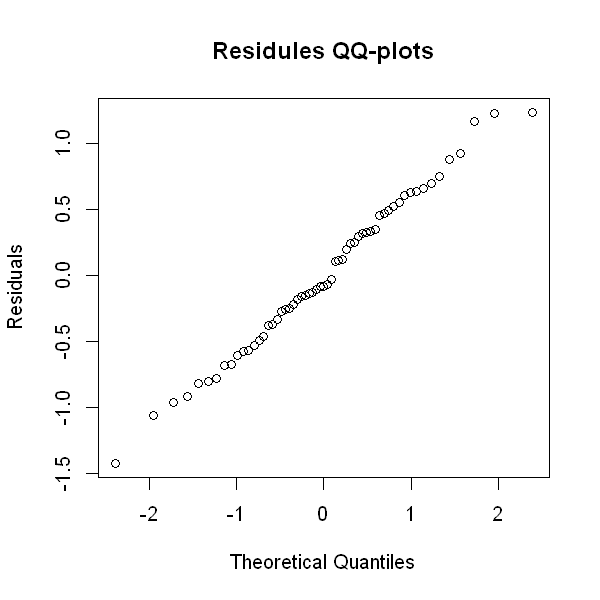

In [322]:
residules = train_y - train_X %*% parameters

options(repr.plot.width=5, repr.plot.height=5)
qqnorm(residules, ylab="Residuals", main="Residules QQ-plots")